In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision import datasets
from torchvision.transforms import Compose, Resize, Lambda, ToTensor, Grayscale, ToPILImage
from torch.utils.data import DataLoader

from imagenet_c import corrupt
from imagenet_c.corruptions import (
    gaussian_noise, shot_noise, impulse_noise, defocus_blur,
    glass_blur, motion_blur, zoom_blur, snow, frost, fog,
    brightness, contrast, elastic_transform, pixelate, jpeg_compression,
    speckle_noise, gaussian_blur, spatter, saturate)
from models import MLP
from utils import test

torch.manual_seed(0)
np.random.seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))

Using cuda device


In [2]:
# Load corruption functions
corruption_tuple = (gaussian_noise, shot_noise, impulse_noise, defocus_blur,
                    glass_blur, motion_blur, 
                    zoom_blur, snow, frost, fog,
                    brightness, contrast, elastic_transform, pixelate, jpeg_compression,
                    speckle_noise, gaussian_blur, spatter, saturate)

corruption_dict = {corr_func.__name__: corr_func for corr_func in corruption_tuple}

# Load model
model = MLP().to(device)
model.load_state_dict(torch.load('../models/MLP_MNIST_weights_20211124_1035.pth'))
model.eval()

# Define variables
BATCH_SIZE = 64


# Test classifier accuracy for different corruptions and severities

In [3]:
df_results = pd.DataFrame(index=['uncorrupted']+list(corruption_dict.keys()), columns=[f'severity={i}' for i in range(1, 6)])

# Uncorrupted baseline
test_data = datasets.MNIST(
                root='../data',
                train=False,
                download=True,
                transform=Compose([
                    # Resize(244),
                    # Grayscale(3), # to RGB
                    # corruption_transform,
                    ToTensor(),
                    # Resize(28),
                    # Grayscale(),

                ])
            )
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)
_, accuracy = test(test_dataloader, model, torch.nn.CrossEntropyLoss(), device)
df_results.loc['uncorrupted', :] = accuracy

# Corrupted
for corruption in tqdm(corruption_dict.keys()):
    
    for severity in range(1, 6):

        try:

            corruption_transform = Lambda(lambda x: corrupt(np.uint8(x), severity=severity, corruption_name=corruption))

            test_data = datasets.MNIST(
                root='../data',
                train=False,
                download=True,
                transform=Compose([
                    # Resize(244),
                    # Grayscale(3), # to RGB
                    corruption_transform,
                    ToTensor(),
                    # Resize(28),
                    # Grayscale(),

                ])
            )

            test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)
            _, accuracy = test(test_dataloader, model, torch.nn.CrossEntropyLoss(), device)
            df_results.loc[corruption, f'severity={severity}'] = accuracy

        except:
            continue

df_results = df_results.dropna()
df_results

100%|██████████| 19/19 [02:03<00:00,  6.48s/it]


,severity=1,severity=2,severity=3,severity=4,severity=5
uncorrupted,0.9775,0.9775,0.9775,0.9775,0.9775
gaussian_noise,0.9701,0.9588,0.9227,0.8137,0.5975
shot_noise,0.978,0.9772,0.9755,0.9706,0.9695
impulse_noise,0.9693,0.9542,0.9334,0.8097,0.6183
contrast,0.7282,0.4414,0.2401,0.0883,0.0891
jpeg_compression,0.9763,0.9753,0.9757,0.9748,0.9734
speckle_noise,0.977,0.9767,0.9745,0.9747,0.9699
gaussian_blur,0.9737,0.915,0.7841,0.6147,0.3601


# Visualize corruptions

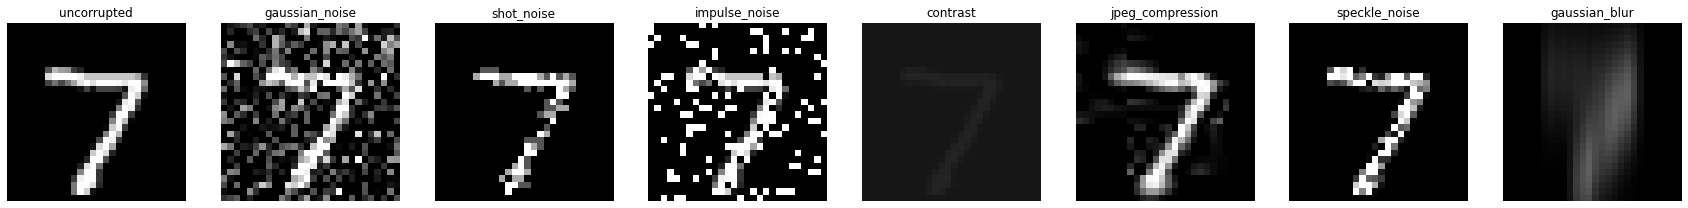

In [4]:
valid_corruptions = df_results.index.tolist()

test_data = datasets.MNIST(
                root='../data',
                train=False,
            )
            
img = test_data[0][0]
img = np.uint8(img)


plt.figure(figsize=(30, 10))
for i, corruption in enumerate(valid_corruptions):

    if corruption == 'uncorrupted':
        img_c = img
    else:
        img_c = corrupt(img, severity=5, corruption_name=corruption)

    plt.subplot(1, len(valid_corruptions), i+1)
    plt.imshow(img_c, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title(corruption)

# Generate dataset including corruption with random severity

(-0.5, 27.5, 27.5, -0.5)

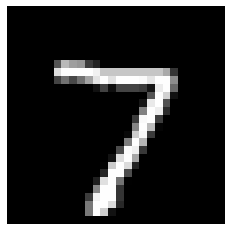

In [5]:
corruption_transform = Lambda(lambda x: corrupt(np.uint8(x), severity=np.random.randint(1, 6), corruption_name='contrast'))

train_data_corrupted = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=Compose([
        corruption_transform,
        ToTensor(),
    ])
)

img = test_data[0][0]
plt.figure()
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')